In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

# 1. Wrangle data

## 1.1 Import & process data

Note: For simplicity, we remove hour/min/sec info, since "adopted" user is based on days.

In [231]:
# Import
df_engage = pd.read_csv('takehome_user_engagement.csv')

# Convert dates to datetime objs
df_engage['time_stamp'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), df_engage['time_stamp'])) # also removes hour, min, sec

print("Rows, columns: ", df_engage.shape)
print("Earliest time_stamp: ", df_engage['time_stamp'].min())
print("Latest time_stamp: ", df_engage['time_stamp'].max(), '\n')
df_engage.head()

Rows, columns:  (207917, 3)
Earliest time_stamp:  2012-05-31 00:00:00
Latest time_stamp:  2014-06-06 00:00:00 



,time_stamp,user_id,visited
0,2014-04-22,1,1
1,2013-11-15,2,1
2,2013-11-29,2,1
3,2013-12-09,2,1
4,2013-12-25,2,1


In [208]:
# Import
df_users = pd.read_csv('takehome_users.csv',  encoding='latin-1')

# Convert dates to datetime objs
df_users['creation_time'] = list(map(lambda x: datetime.strptime(x.split()[0],'%Y-%m-%d'), df_users['creation_time'])) # also removes hour, min, sec

print("Rows, columns: ", df_users.shape)
print("Earliest creation_time: ", df_users['creation_time'].min())
print("Latest creation_time: ", df_users['creation_time'].max())
df_users.head()

Rows, columns:  (12000, 10)
Earliest creation_time:  2012-05-31 00:00:00
Latest creation_time:  2014-05-30 00:00:00


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### Check number of users

In [209]:
print("Number of unique user id's: ", len(df_users['object_id'].unique()))
print("Number of unique user names: ", len(df_users['name'].unique()))
print("Number of unique emails: ", len(df_users['email'].unique()))

Number of unique user id's:  12000
Number of unique user names:  11355
Number of unique emails:  11980


#### Check distribution of logins

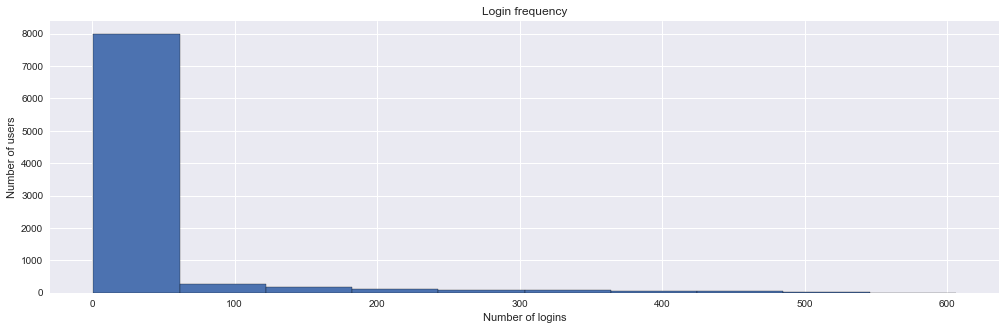

In [210]:
plt.figure(figsize=(17,5));
plt.hist(df_engage.groupby('user_id').size());
plt.title('Login frequency');
plt.xlabel('Number of logins');
plt.ylabel('Number of users');

### Observations
- There are 12000 unique users. However, the number of unique names (11355) and emails (11980) do not match - there may be individuals duplicated in the database. If we assume different individuals have identical names and go by email as the reference point for identifying duplicated individuals, we'd only have 20 duplicated individuals in our database. That's pretty small, so for simplicity we stick with 'object_id' (user id) as the reference point for looking up each individual's logins.
- Data spans 2012-2014.
- Majority of users have < 50 logins. There is also a small but significant cluster of users who are clearly active, adopted users w/ > 100 logins.

# 2. Identify & examine adopted users

#### Grab each user's logins

In [195]:
user_timestamps = [] # list of arrays, where each array is a user's logins
for idx, row in df_users.iterrows():
    user_id = row['object_id']
    timestamps = df_engage[df_engage['user_id']==user_id]['time_stamp']
    t = [i for i in timestamps]
    user_timestamps.append(t)

#### Define function to determine whether user has logged in on 3 separate days in at least one 7-day period

This is predicated on calculating time elapsed between each login. In the case that multiple logins occur on the same day, which might confound this analysis, we remove these "duplicate" logins.

In [196]:
def adopted(x): # x = list of user's logins ('Timestamp' data type)
    if len(x) < 3:
        return 0
    else:
        x.sort()  
        y = [x[i+1] - x[i] for i in range(len(x)-2)] # amount of days between logins
        y = [i for i in y if i > np.timedelta64(0, 'ns')] # delete extra logins occurring on same day
        z = [1 for i in range(len(y)-2) if y[i] + y[i+1] + y[i+2] <= timedelta(days=7)]
        # condition to check if there`s a 1 in x, return 1 if true
        if 1 in z:
            return 1
        else:
            return 0

####  Identify adopted users

Adopted user is user who has logged into the product on three separate days in at least one seven-day period.

In [232]:
adopt_total = []
for user in user_timestamps:
        adopt_total.append(adopted(user))

df_users['adopted'] = adopt_total

In [233]:
print("Number of adopted users: ", sum(adopt_total))
print("Fraction adopted users: ", sum(adopt_total)/len(adopt_total))

Number of adopted users:  1322
Fraction adopted users:  0.11016666666666666


11% of customers are adopted users. That means many users who aren't adopted, which will definitely be valuable for the company to target.

# 3. Examine features

#### Make dataframe of features, dropping irrelevant info such as name, email, etc.

In [289]:
df_features = pd.DataFrame.copy(df_users)

In [236]:
df_features = pd.DataFrame.copy(df_users)
df_features = df_features.drop(['name', 'email', 'object_id', 'creation_time', 
                                'last_session_creation_time', 'invited_by_user_id'], axis=1)
df_features.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,0
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


#### Convert features to numeric

Only one we have to convert is 'creation_source'.

In [239]:
print('Unique creation sources: ', df_features['creation_source'].unique())

Unique creation sources:  ['GUEST_INVITE' 'ORG_INVITE' 'SIGNUP' 'PERSONAL_PROJECTS'
 'SIGNUP_GOOGLE_AUTH']


Convert:
- 'GUEST_INVITE' = 0
- 'ORG_INVITE' = 1
- 'SIGNUP' = 2
- 'PERSONAL_PROJECTS' = 3
- 'SIGNUP_GOOGLE_AUTH' = 4

In [241]:
creation = {'GUEST_INVITE':0,
            'ORG_INVITE':1,
            'SIGNUP':2,
            'PERSONAL_PROJECTS':3,
            'SIGNUP_GOOGLE_AUTH':4}
df_features['creation_source'] = df_features['creation_source'].map(lambda i: creation[i])

#### Examine distribution of features

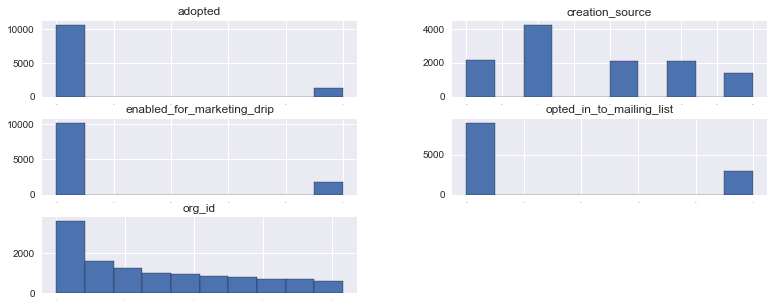

In [243]:
df_features.hist(sharex=False, sharey=False, xlabelsize=1, figsize=(13,5));

None of the features have a continuous normal distribution.

#### Scale features

We're choosing between <b>StandardScaler</b> and <b>MinMaxScaler</b>. Mix-max more appropriate for data that aren't normally distributed. From above, we can see that's the case. So we'll use [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [245]:
from sklearn.preprocessing import MinMaxScaler

x = df_features.drop('adopted', axis=1)
y = df_users['adopted']

scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.fit_transform(x)

In [251]:
# Temporarily put into dataframe to easily visualize how features have been converted
pd.DataFrame(x).head()

,0,1,2,3
0,0.00,1.0,0.0,0.026442
1,0.25,0.0,0.0,0.002404
2,0.25,0.0,0.0,0.225962
3,0.00,0.0,0.0,0.002404
4,0.00,0.0,0.0,0.463942


#### Correlation matrix of features

To examine whether there is correlation among the features.

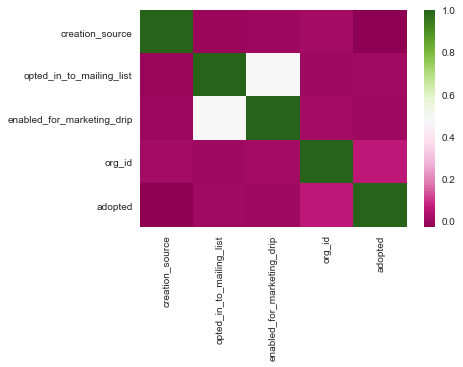

In [252]:
sns.heatmap(df_features.corr(), cmap="PiYG");

<i>'Enabled_for_marketing_drop'</i> and <i>'opted_in_to_mailing_list'</i> appear highly correlated. We'll keep this in mind if we need to drop features to improve our model, since intercorrelated features may hinder model performance.

# 4. Test models

We test several models, narrow down to one, then tune parameters.

#### Split features into train/test sets.

In [254]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

#### Test multiple ML approaches at once.

In [261]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score
#from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier

num_folds=10
scoring='roc_auc'

models=[]
models.append(('LR', LogisticRegression()))
models.append(('KN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('B', MultinomialNB()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=99)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.566996 (0.034307)
KN: 0.543460 (0.037450)
RF: 0.521580 (0.045219)
B: 0.559270 (0.037503)


We pick logistic regression, since it has the best ROC-AUC.

#### Tune model

Tune the model to see if we can obtain further improvements.

In [264]:
from sklearn.metrics import confusion_matrix

# Re-instantiate model
model = LogisticRegression() # instantiate logreg w/ l1 regularization
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[3209    0]
 [ 391    0]]


- The performance is fantastic at not having false positives (non-adopted users falsed identified as adopted). That means no un-adopted user slips through the cracks if Relax Inc. decides to target non-adopted users w/ specific ads, etc. for retaining them.
- However, we have 391 false negatives - adopted users misclassified as non-adopters. This might not be as big of an issue though, depending on Relax's strategy of targeting non-adopted users. Maybe they will continue to be adopters, even if they are targeted w/ non-adopter ads, for instance. This would mean FN's aren't costly.

Regardless, let's see if we can get better performance w/ [Lasso regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).

In [265]:
model = LogisticRegression(penalty='l1') # instantiate logreg w/ l1 regularization
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Confusion matrix
print('Confusion matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion matrix: 
[[3209    0]
 [ 391    0]]


It's actually the same in this case. Perhaps just for this train/test split, but the difference seems likely to be small.

# 5. Examine feature importance

#### Plot relative importance of features

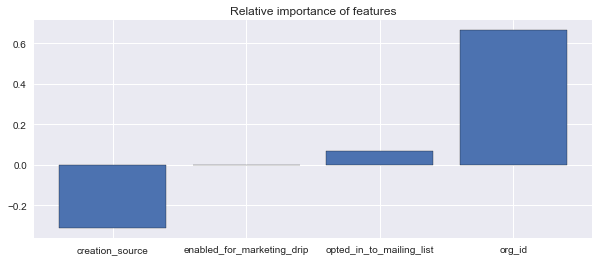

In [286]:
features = df_features.columns[:-1].tolist()
coefs = model.coef_[0]

plt.figure(figsize=(10,4));
plt.bar(features, coefs);
plt.title('Relative importance of features');

<b>'creation_source'</b> and <b>'org_id'</b> seem to be most important. It's difficult to make a specific recommendation since we only know that they're heavily weighted. So let's examine them more closely.

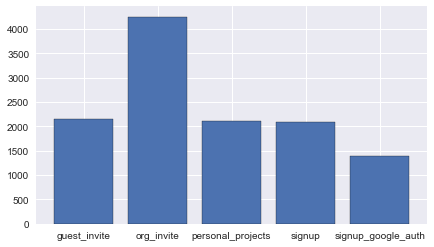

In [305]:
names = ['guest_invite', 'org_invite', 'signup', 'personal_projects', 'signup_google_auth']
count = df_users.groupby('creation_source').size().tolist()

plt.figure(figsize=(7,4));
plt.bar(names, count);

Most common creation source seems to be 'org_invite'. This makes sense, since 'org_id' is our other feature w/ relatively large weight. Let's examine 'org_id' next.

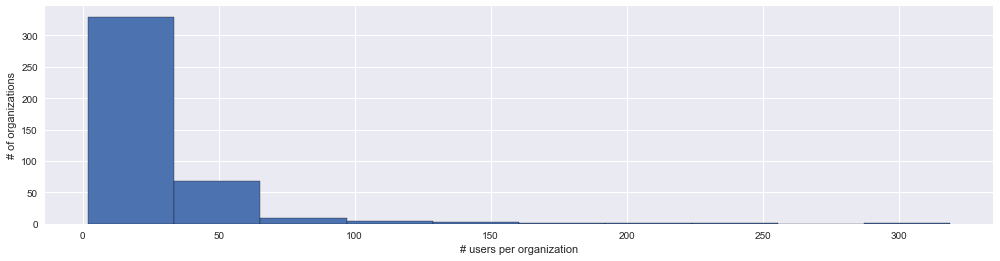

In [347]:
count = df_users.groupby('org_id').size()
plt.figure(figsize=(17,4))
plt.hist(count);
plt.xlabel('# users per organization');
plt.ylabel('# of organizations');

Majority of organizations (group of users, by 'org_id') seem to have < 70 members. However, there are a few large organizations with many more members. Let's examine them more closely.

Total organizations w/ > 70 users:  18


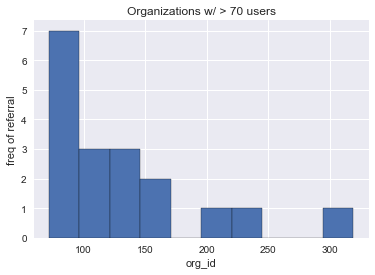

In [350]:
test = pd.DataFrame({'count':count.tolist(), 'org_id':count.index})
test = test[test['count'] > 70]['count']
plt.hist(test);
plt.xlabel('org_id');
plt.ylabel('freq of referral');
plt.title('Organizations w/ > 70 users');
print('Total organizations w/ > 70 users: ', len(test))

There are 18 organizations w/ > 70 users. These organizations might be worth targeting to get more even users.

# 6. Conclusion

Our most important features were 'org_id' and 'creation_source'. It seems that many of Relax Inc's users are influenced to adopt by virtue of being part of an organization or how they were invited.

Upon closer examination of these features, whether the user was prompted to adopt due to being part of an organization is probably the most important factor in determining whether they adopt. There are ~18 organizations with > 70 users. 

<b>Recommendation</b>: To increase number of adopters, it may be more fruitful to target organizations rather than individual customers - in particular, focusing on encouraging organizations to enroll large numbers of their members. Individual-level factors such as how users signed up (not including via an organization) and whether they were on a mailing list are not nearly as important as whether they were part of an organization.